<a href="https://colab.research.google.com/github/ElhaliAmina/Deep_Learning_Tp/blob/main/amina.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import json
import math
import os
import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.applications import ResNet50
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical# convert to one-hot-encoding
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools
%matplotlib inline
from glob import glob
from keras import Model
from keras.callbacks import ReduceLROnPlateau, EarlyStopping


In [2]:
! pip install -q kaggle

In [3]:
from google.colab import files

In [4]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"elhaliamina","key":"130cd80046a793218c4e2b6e69f15476"}'}

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download "nodoubttome/skin-cancer9-classesisic"


kaggle.json
 99% 779M/786M [00:05<00:00, 147MB/s]
100% 786M/786M [00:05<00:00, 159MB/s]


In [6]:
!unzip skin-cancer9-classesisic.zip

Archive:  skin-cancer9-classesisic.zip
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024646.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024654.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024707.jpg  
  inflating: Skin cancer 

In [7]:
DATADIR_Train = '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train'
DATADIR_Test = '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test'

In [8]:
CATEGORIES  = list()
for root, dirs, files in os.walk(DATADIR_Train, topdown=False):
    for name in dirs:
        CATEGORIES.append(os.path.join(name))
print (CATEGORIES)

['basal cell carcinoma', 'seborrheic keratosis', 'nevus', 'melanoma', 'actinic keratosis', 'pigmented benign keratosis', 'squamous cell carcinoma', 'vascular lesion', 'dermatofibroma']


In [10]:

x_train_data = []
y_train_data = []
IMG_SIZE=50
def create_training_data():
    for category in CATEGORIES:
      path = os.path.join(DATADIR_Train, category)
      class_num = CATEGORIES.index(category)
      for img in os.listdir(path):
        try:
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
            new_array = cv2.resize(img_array, (IMG_SIZE,IMG_SIZE))
            x_train_data.append(new_array)
            y_train_data.append(class_num)
        except Exception as e:
            pass
create_training_data()

In [11]:

x_test_data = []
y_test_data = []
IMG_SIZE=50
def create_testing_data():
    for category in CATEGORIES:
      path = os.path.join(DATADIR_Test, category)
      class_num = CATEGORIES.index(category)
      for img in os.listdir(path):
        try:
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
            new_array = cv2.resize(img_array, (IMG_SIZE,IMG_SIZE))
            x_test_data.append(new_array)
            y_test_data.append(class_num)
        except Exception as e:
            pass
create_testing_data()

In [12]:
X_Train, X_Val, Y_Train, Y_Val = train_test_split(x_train_data, y_train_data, test_size=0.1, random_state=1)

In [13]:
X_Train = np. squeeze(np.array(X_Train))
X_Val = np. squeeze(np.array(X_Val))
Y_Train = np. squeeze(np.array(Y_Train))
Y_Val = np. squeeze(np.array(Y_Val))
x_test_data = np. squeeze(np.array(x_test_data))

In [14]:
X_Train.shape

(2015, 50, 50, 3)

In [15]:
Y_Train.shape

(2015,)

In [16]:
x_test_data.shape

(118, 50, 50, 3)

In [17]:
X_Val.shape

(224, 50, 50, 3)

In [18]:
Y_Val.shape

(224,)

In [19]:
Y_Train = to_categorical(Y_Train)
Y_Val = to_categorical(Y_Val)

In [20]:
Y_Train.shape

(2015, 9)

In [21]:
Y_Val.shape

(224, 9)

## Load in Pretrained VGG16 Model

In [22]:
IMG_SHAPE = (50, 50,3)

In [23]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

In [24]:
#datagen= ImageDataGenerateur(rescale=1.0/255)
base_model = VGG16(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

58892288/58889256 [==============================] - 0s 0us/step


In [25]:
for layer in base_model.layers:
    print(layer.name)
    layer.trainable = False
    
print(len(base_model.layers))

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool
19


In [26]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50, 50, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 50, 50, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 50, 50, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 25, 25, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 25, 25, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 25, 25, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0     

In [27]:
last_layer = base_model.get_layer('block5_pool')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 1, 1, 512)


In [28]:
base_model.trainable = False

In [29]:
base_model.output

<KerasTensor: shape=(None, 1, 1, 512) dtype=float32 (created by layer 'block5_pool')>

In [30]:
from tqdm import tqdm_notebook
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import load_model, Model

%matplotlib inline
tf.__version__

'2.4.0'

In [31]:
# Flatten the output layer to 1 dimension
x = layers.GlobalMaxPooling2D()(base_model.output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)
# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(9, activation='softmax')(x)

# Configure and compile the model
model = Model(base_model.input, x)
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [32]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50, 50, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 50, 50, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 50, 50, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 25, 25, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 25, 25, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 25, 25, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0     

In [33]:
train_datagen = ImageDataGenerator(rescale = 1./255, rotation_range=60, width_shift_range=0.2, height_shift_range=0.2,
                                   shear_range=0.2, zoom_range=0.2, fill_mode='nearest')

In [34]:
train_datagen.fit(X_Train)

In [35]:
val_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen.fit(X_Val)

In [38]:
history = model.fit(X_Train, Y_Train, batch_size=64, epochs=20,
                    validation_data=(X_Val, Y_Val))

Epoch 1/20
32/32 [==============================] - 1s 25ms/step - loss: 6.3120 - accuracy: 0.4194 - val_loss: 3.4076 - val_accuracy: 0.5536
Epoch 2/20
32/32 [==============================] - 1s 22ms/step - loss: 5.8757 - accuracy: 0.4333 - val_loss: 3.2303 - val_accuracy: 0.5446
Epoch 3/20
32/32 [==============================] - 1s 22ms/step - loss: 5.5017 - accuracy: 0.4283 - val_loss: 3.1828 - val_accuracy: 0.5580
Epoch 4/20
32/32 [==============================] - 1s 22ms/step - loss: 5.2739 - accuracy: 0.4342 - val_loss: 3.1262 - val_accuracy: 0.5491
Epoch 5/20
32/32 [==============================] - 1s 22ms/step - loss: 4.9121 - accuracy: 0.4437 - val_loss: 2.9413 - val_accuracy: 0.5804
Epoch 6/20
32/32 [==============================] - 1s 22ms/step - loss: 4.5178 - accuracy: 0.4486 - val_loss: 2.8148 - val_accuracy: 0.5848
Epoch 7/20
32/32 [==============================] - 1s 22ms/step - loss: 4.5898 - accuracy: 0.4561 - val_loss: 2.8220 - val_accuracy: 0.5759
Epoch 8/20
32

## Fine Tuning Model

In [39]:
for layer in model.layers[:15]:
    layer.trainable = False

for layer in model.layers[15:]:
    layer.trainable = True

In [40]:
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])

In [41]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50, 50, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 50, 50, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 50, 50, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 25, 25, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 25, 25, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 25, 25, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0     

By setting the last convolutional block to trainable, we are now retraining for half of the hyperparameters

In [42]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, 
                                            min_lr=0.000001, cooldown=3)

In [43]:
history = model.fit(X_Train, Y_Train, batch_size=64, epochs=30,
                    validation_data=(X_Val, Y_Val))

Epoch 1/30
32/32 [==============================] - 2s 38ms/step - loss: 2.8640 - acc: 0.4440 - val_loss: 1.6492 - val_acc: 0.4286
Epoch 2/30
32/32 [==============================] - 1s 30ms/step - loss: 1.8081 - acc: 0.4199 - val_loss: 1.3786 - val_acc: 0.5446
Epoch 3/30
32/32 [==============================] - 1s 30ms/step - loss: 1.4127 - acc: 0.5212 - val_loss: 1.2856 - val_acc: 0.5625
Epoch 4/30
32/32 [==============================] - 1s 30ms/step - loss: 1.2092 - acc: 0.5839 - val_loss: 1.2500 - val_acc: 0.5893
Epoch 5/30
32/32 [==============================] - 1s 30ms/step - loss: 1.0563 - acc: 0.6276 - val_loss: 1.2682 - val_acc: 0.5759
Epoch 6/30
32/32 [==============================] - 1s 30ms/step - loss: 0.9224 - acc: 0.6762 - val_loss: 1.2323 - val_acc: 0.5759
Epoch 7/30
32/32 [==============================] - 1s 30ms/step - loss: 0.8245 - acc: 0.7260 - val_loss: 1.2399 - val_acc: 0.6071
Epoch 8/30
32/32 [==============================] - 1s 30ms/step - loss: 0.7080 - a

In [44]:
loss_val, acc_val = model.evaluate(X_Val, Y_Val, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (acc_val, loss_val))

7/7 [==============================] - 0s 18ms/step - loss: 1.9246 - acc: 0.5714
Validation: accuracy = 0.571429  ;  loss_v = 1.924556


## Testing

In [45]:
y_test_data = to_categorical(y_test_data)
loss_test, acc_test = model.evaluate(x_test_data, y_test_data, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (acc_test, loss_test))

4/4 [==============================] - 0s 95ms/step - loss: 3.9946 - acc: 0.4237
Test: accuracy = 0.423729  ;  loss = 3.994644


In [46]:
model.save("VGG16.h5")

Text(0.5, 1.0, 'Training and validation loss')

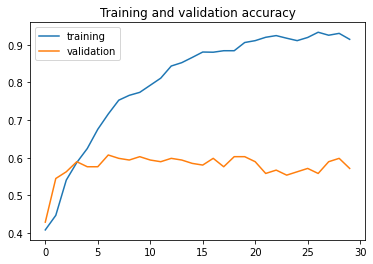

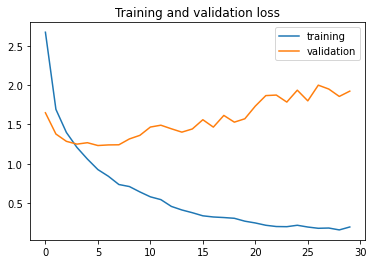

In [47]:
# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label = "training")
plt.plot(epochs, val_acc, label = "validation")
plt.legend(loc="upper left")
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, label = "training")
plt.plot(epochs, val_loss, label = "validation")
plt.legend(loc="upper right")
plt.title('Training and validation loss')